In [ ]:
%pip install tensorflow
%pip install opencv-python

In [ ]:
%pip install -U scikit-learn

In [13]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

img_w, img_h = 40, 204

# Define a basic CNN architecture for license plate recognition
class LicensePlateCNN(nn.Module):
    def __init__(self):
        super(LicensePlateCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * (img_w // 4) * (img_h // 4), 512)
        self.dropout = nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(512, 10 * (26 + 10 + 1))

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * (img_w // 4) * (img_h // 4))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to move data to the specified device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

losses = []

# Define a function to train the model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, test_interval=10, device='cpu'):
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in train_loader:
            inputs, labels = to_device(inputs, device), to_device(labels, device)
            #print('Label shape', labels.shape)
            #print('Input shape', inputs.shape)
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
        losses.append(loss.item())
        
        if epoch % test_interval == 0:
            test_model(model, train_loader)

# Define a function to test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = to_device(inputs, device), to_device(labels, device)
            outputs = model(inputs)
            total += labels.size(0)
            
            for i in range(outputs.size(0)):
                pred = outputs[i, :].cpu()
                act = labels[i, :].cpu()
                pred_label = tensor_to_label(pred, 10)
                act_label = tensor_to_label(act, max_length=10)
                if pred_label == act_label :
                    correct += 1
                    #print(pred_label)
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

In [14]:
import torch

letter_list = 'abcdefghijklmnopqrstuvwxyz0123456789'

def label_to_tensor(text, max_length = 7):
    num_letters = 26
    num_numbers = 10
    num_empty = 1
    
    offset =  (num_letters + num_numbers + num_empty)

    tensor_size = max_length * offset
    tensor = torch.zeros(tensor_size, dtype=torch.float32)

    idx = 0
    for char in text:
        tensor[idx + letter_list.find(char.lower()) + 1] = 1.0
        idx += offset

    return tensor

import torch

def tensor_to_label(tensor, max_length = 7):
    num_letters = 26
    num_numbers = 10
    num_empty = 1

    char_list = []

    for i in range(max_length):
        start_idx = i * (num_letters + num_numbers + num_empty)
        end_idx = start_idx + (num_letters + num_numbers + num_empty)

        section = tensor[start_idx:end_idx] > 0.5

        # Find the index of the first element greater than 0.5
        index = torch.nonzero(section > 0.5, as_tuple=False)
        
        if index.numel() > 0:
            first_greater_than_0_5 = index[0].item()
            if first_greater_than_0_5 > 0.5:
                char_list.append(letter_list[first_greater_than_0_5 - 1])
            else:
                char_list += ' '
        else:
            char_list += ' '

    return ''.join(char_list)

# Example usage
text = "abc-123"
tensor_representation = label_to_tensor(text)
inverse_result = tensor_to_label(tensor_representation)
print(inverse_result)


abc 123


In [15]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.file_list = [file for file in os.listdir(root) if file.endswith('.png')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = os.path.splitext(self.file_list[idx])[0]  # Get the filename without extension
        label = label_to_tensor(label, max_length=10)

        return image, label

In [18]:
# Set the path to your dataset
data_path = "data/images_synthetic/licenseplates"

device = 'mps'

threshold = 0.5  # You can adjust this threshold as needed
to_binary = lambda x: 1 if x > threshold else 0

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),  # Adjust the size based on your input image size
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.apply_(to_binary))
])

# Create a dataset and data loader
dataset = CustomDataset(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LicensePlateCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, device=device, test_interval=10)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 38.6589469909668
Test Accuracy: 0.00%
Epoch 2/50, Loss: 33.666175842285156


KeyboardInterrupt: 

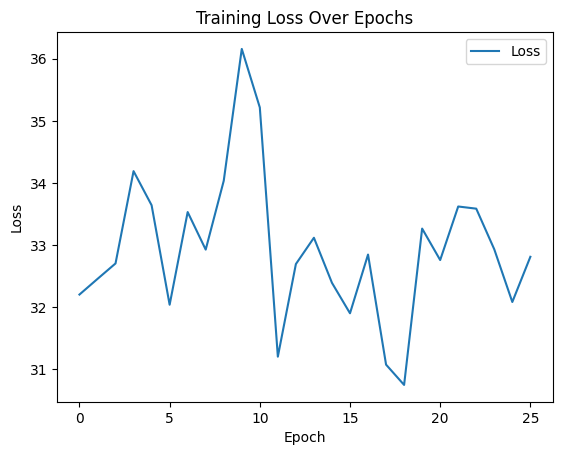

In [17]:
import matplotlib.pyplot as plt

# Plot the losses
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [7]:
test_model(model, test_loader)

Test Accuracy: 0.00%
